In [1]:
import psycopg2
import random
import time
from time import strftime, localtime

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.impute import SimpleImputer

print("Start: %s" % strftime("%b %d %Y %H:%M:%S", localtime()))
try:
    conn = psycopg2.connect("dbname='homecredit' user='postgres' host='localhost' password='metis'")
except w:
    print(w)
    print ("I am unable to connect to the database")

Start: Oct 28 2018 12:02:00


In [2]:
%time application_train = pd.read_csv("data/application_train.csv")

application_test = pd.read_csv("data/application_test.csv")


CPU times: user 4.94 s, sys: 1.66 s, total: 6.59 s
Wall time: 9.17 s


In [3]:
set(application_train.columns) - set(application_test.columns) 

{'TARGET'}

In [4]:
# An interesting issue is what to do when you one_hot a categorical variable
# and new values show up in test. If you one-hot the test data, now your
# columns are not aligned.
# For now, let's concatenate train and test , mark test with target -1
# then disaggregate train and test
cols = application_train.columns
application_test['TARGET'] = -1
print(set(application_train.columns) - set(application_test.columns) )

set()


In [5]:
# concat, align column order
application = pd.concat([application_train, application_test], sort=True)


# Add  engineered features


In [6]:
def add_engineered_columns(df):
    # ratios
    df['RATE_CREDIT_INCOME'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['RATE_ANNUITY_INCOME'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['RATE_PAYMENT_CREDIT'] =df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    df['RATE_CREDIT_VALUE'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']

    # ext sources
    df['RATE_INCOME_EXT1'] = df['AMT_INCOME_TOTAL'] / df['EXT_SOURCE_1']
    df['RATE_CREDIT_EXT1'] = df['AMT_CREDIT'] / df['EXT_SOURCE_1']
    df['RATE_PAYMENT_EXT1'] =df['AMT_ANNUITY'] / df['EXT_SOURCE_1']
    
    df['RATE_INCOME_EXT2'] = df['AMT_INCOME_TOTAL'] / df['EXT_SOURCE_2']
    df['RATE_CREDIT_EXT2'] = df['AMT_CREDIT'] / df['EXT_SOURCE_2']
    df['RATE_PAYMENT_EXT2'] =df['AMT_ANNUITY'] / df['EXT_SOURCE_2']
    
    df['RATE_INCOME_EXT3'] = df['AMT_INCOME_TOTAL'] / df['EXT_SOURCE_3']
    df['RATE_CREDIT_EXT3'] = df['AMT_CREDIT'] / df['EXT_SOURCE_3']
    df['RATE_PAYMENT_EXT3'] =df['AMT_ANNUITY'] / df['EXT_SOURCE_3']
    
    # quantiles for population
    
    df["REGION_POPULATION_QUANTILE"] = pd.qcut(df["REGION_POPULATION_RELATIVE"], 10, labels=False)
    #df["REGION_POPULATION_QUANTILE"] = df["REGION_POPULATION_QUANTILE"].astype(int)

add_engineered_columns(application)
    
application.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,RATE_INCOME_EXT1,RATE_CREDIT_EXT1,RATE_PAYMENT_EXT1,RATE_INCOME_EXT2,RATE_CREDIT_EXT2,RATE_PAYMENT_EXT2,RATE_INCOME_EXT3,RATE_CREDIT_EXT3,RATE_PAYMENT_EXT3,REGION_POPULATION_QUANTILE
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2.438673e+06,4.896584e+06,297463.898020,770112.507104,1.546300e+06,93936.612255,1.452907e+06,2.917275e+06,177222.326450,4
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.674216e+05,4.155600e+06,114687.597106,433912.146513,2.078765e+06,57370.417638,NaN,NaN,NaN,0
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,121422.077369,2.428442e+05,12142.207737,9.252067e+04,1.850413e+05,9252.067132,2
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,207551.271685,4.807233e+05,45640.524644,NaN,NaN,NaN,1
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,376466.024966,1.589523e+06,67749.941308,NaN,NaN,NaN,7


# Drop redundant columns

In [7]:
cols_to_drop = ['APARTMENTS_MEDI',
                'APARTMENTS_MODE',
                'BASEMENTAREA_MEDI',
                'BASEMENTAREA_MODE',
                'COMMONAREA_MEDI',
                'COMMONAREA_MODE',
                'ELEVATORS_MEDI',
                'ELEVATORS_MODE',
                'ENTRANCES_MEDI',
                'ENTRANCES_MODE',
                'FLOORSMAX_MEDI',
                'FLOORSMAX_MODE',
                'FLOORSMIN_MEDI',
                'FLOORSMIN_MODE',
                'LANDAREA_MEDI',
                'LANDAREA_MODE',
                'LIVINGAPARTMENTS_MEDI',
                'LIVINGAPARTMENTS_MODE',
                'LIVINGAREA_MEDI',
                'LIVINGAREA_MODE',
                'NONLIVINGAPARTMENTS_MEDI',
                'NONLIVINGAPARTMENTS_MODE',
                'NONLIVINGAREA_MEDI',
                'NONLIVINGAREA_MODE',
                'YEARS_BEGINEXPLUATATION_MEDI',
                'YEARS_BEGINEXPLUATATION_MODE',
                'YEARS_BUILD_MEDI',
                'YEARS_BUILD_MODE',
                'AMT_GOODS_PRICE'                
               ]

def drop_columns(df, cols_to_drop):
    """drop columns not used in model"""
    for col in cols_to_drop:
        print("Dropping column %s" % col)
        df.drop(col, axis=1, inplace=True)
        
drop_columns(application, cols_to_drop)

application.head()


Dropping column APARTMENTS_MEDI
Dropping column APARTMENTS_MODE
Dropping column BASEMENTAREA_MEDI
Dropping column BASEMENTAREA_MODE
Dropping column COMMONAREA_MEDI
Dropping column COMMONAREA_MODE
Dropping column ELEVATORS_MEDI
Dropping column ELEVATORS_MODE
Dropping column ENTRANCES_MEDI
Dropping column ENTRANCES_MODE
Dropping column FLOORSMAX_MEDI
Dropping column FLOORSMAX_MODE
Dropping column FLOORSMIN_MEDI
Dropping column FLOORSMIN_MODE
Dropping column LANDAREA_MEDI
Dropping column LANDAREA_MODE
Dropping column LIVINGAPARTMENTS_MEDI
Dropping column LIVINGAPARTMENTS_MODE
Dropping column LIVINGAREA_MEDI
Dropping column LIVINGAREA_MODE
Dropping column NONLIVINGAPARTMENTS_MEDI
Dropping column NONLIVINGAPARTMENTS_MODE
Dropping column NONLIVINGAREA_MEDI
Dropping column NONLIVINGAREA_MODE
Dropping column YEARS_BEGINEXPLUATATION_MEDI
Dropping column YEARS_BEGINEXPLUATATION_MODE
Dropping column YEARS_BUILD_MEDI
Dropping column YEARS_BUILD_MODE
Dropping column AMT_GOODS_PRICE


,AMT_ANNUITY,AMT_CREDIT,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,...,RATE_INCOME_EXT1,RATE_CREDIT_EXT1,RATE_PAYMENT_EXT1,RATE_INCOME_EXT2,RATE_CREDIT_EXT2,RATE_PAYMENT_EXT2,RATE_INCOME_EXT3,RATE_CREDIT_EXT3,RATE_PAYMENT_EXT3,REGION_POPULATION_QUANTILE
0,24700.5,406597.5,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0247,...,2.438673e+06,4.896584e+06,297463.898020,770112.507104,1.546300e+06,93936.612255,1.452907e+06,2.917275e+06,177222.326450,4
1,35698.5,1293502.5,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0959,...,8.674216e+05,4.155600e+06,114687.597106,433912.146513,2.078765e+06,57370.417638,NaN,NaN,NaN,0
2,6750.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,121422.077369,2.428442e+05,12142.207737,9.252067e+04,1.850413e+05,9252.067132,2
3,29686.5,312682.5,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,207551.271685,4.807233e+05,45640.524644,NaN,NaN,NaN,1
4,21865.5,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,376466.024966,1.589523e+06,67749.941308,NaN,NaN,NaN,7


# Determine numeric/categorical/binary

In [8]:
# if this many or fewer unique values, assume it's categorical
# determine which columns are numerical, categorical, or binary
MAX_UNIQUE_CATEGORY = 10

binary = []
categorical = []
numeric = []

cols = application.columns

for col in cols:
    # is it numeric?
    is_numeric = np.issubdtype(application[col].dtype, np.number)
    # how may unique values?
    uniques = len(application[col].unique())

    if uniques == 2: # binary whether numeric or not
        binary.append(col)
    elif not is_numeric: # categorical
        categorical.append(col)
    elif uniques <= MAX_UNIQUE_CATEGORY: # numeric but only a few uniques
        categorical.append(col)
    else:
        numeric.append(col)
        print("%30s: %d" % (col, uniques))

print("Numeric columns: %d" %len(numeric))
print("Binary columns:  %d" %len(binary))
print("Categorical columns:  %d" %len(categorical))

binary.sort()
categorical.sort()
numeric.sort()


                   AMT_ANNUITY: 14167
                    AMT_CREDIT: 6480
              AMT_INCOME_TOTAL: 2741
     AMT_REQ_CREDIT_BUREAU_MON: 25
     AMT_REQ_CREDIT_BUREAU_QRT: 12
    AMT_REQ_CREDIT_BUREAU_YEAR: 26
                APARTMENTS_AVG: 2392
              BASEMENTAREA_AVG: 3832
                  CNT_CHILDREN: 16
               CNT_FAM_MEMBERS: 19
                COMMONAREA_AVG: 3272
                    DAYS_BIRTH: 17467
                 DAYS_EMPLOYED: 12896
               DAYS_ID_PUBLISH: 6224
        DAYS_LAST_PHONE_CHANGE: 3847
             DAYS_REGISTRATION: 15898
      DEF_30_CNT_SOCIAL_CIRCLE: 11
                 ELEVATORS_AVG: 267
                 ENTRANCES_AVG: 295
                  EXT_SOURCE_1: 134316
                  EXT_SOURCE_2: 127158
                  EXT_SOURCE_3: 815
                 FLOORSMAX_AVG: 415
                 FLOORSMIN_AVG: 319
       HOUR_APPR_PROCESS_START: 24
                  LANDAREA_AVG: 3581
          LIVINGAPARTMENTS_AVG: 1918
            

In [9]:
# Fix some default assignments

def numeric_to_cat(str):
    if str in numeric:
        print("Move %s to categorical" % str)
        numeric.remove(str)
        categorical.append(str)
        categorical.sort()

def cat_to_numeric(str):
    if str in categorical:
        print("Move %s to numeric" % str)
        categorical.remove(str)
        numeric.append(str)
        categorical.sort()
        
numeric_to_cat('DEF_60_CNT_SOCIAL_CIRCLE')
numeric_to_cat('DEF_30_CNT_SOCIAL_CIRCLE')
# don't want to do anything with TARGET, SK_ID_CURR
categorical.remove('TARGET')
numeric.remove('SK_ID_CURR')


Move DEF_30_CNT_SOCIAL_CIRCLE to categorical


In [10]:
numeric

['AMT_ANNUITY',
 'AMT_CREDIT',
 'AMT_INCOME_TOTAL',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'CNT_CHILDREN',
 'CNT_FAM_MEMBERS',
 'COMMONAREA_AVG',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_REGISTRATION',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'HOUR_APPR_PROCESS_START',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'OWN_CAR_AGE',
 'RATE_ANNUITY_INCOME',
 'RATE_CREDIT_EXT1',
 'RATE_CREDIT_EXT2',
 'RATE_CREDIT_EXT3',
 'RATE_CREDIT_INCOME',
 'RATE_CREDIT_VALUE',
 'RATE_INCOME_EXT1',
 'RATE_INCOME_EXT2',
 'RATE_INCOME_EXT3',
 'RATE_PAYMENT_CREDIT',
 'RATE_PAYMENT_EXT1',
 'RATE_PAYMENT_EXT2',
 'RATE_PAYMENT_EXT3',
 'REGION_POPULATION_RELATIVE',
 'TOTAL

In [11]:
categorical

['AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'CODE_GENDER',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'EMERGENCYSTATE_MODE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'NAME_INCOME_TYPE',
 'NAME_TYPE_SUITE',
 'OCCUPATION_TYPE',
 'ORGANIZATION_TYPE',
 'REGION_POPULATION_QUANTILE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WALLSMATERIAL_MODE',
 'WEEKDAY_APPR_PROCESS_START']

In [12]:
binary

['FLAG_CONT_MOBILE',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_EMAIL',
 'FLAG_EMP_PHONE',
 'FLAG_MOBIL',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FLAG_PHONE',
 'FLAG_WORK_PHONE',
 'LIVE_CITY_NOT_WORK_CITY',
 'LIVE_REGION_NOT_WORK_REGION',
 'NAME_CONTRACT_TYPE',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION']

In [13]:
application.groupby(['AMT_REQ_CREDIT_BUREAU_HOUR']).count()
#could prob bucket 2, 3 and 4 together

,AMT_ANNUITY,AMT_CREDIT,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,BASEMENTAREA_AVG,...,RATE_INCOME_EXT1,RATE_CREDIT_EXT1,RATE_PAYMENT_EXT1,RATE_INCOME_EXT2,RATE_CREDIT_EXT2,RATE_PAYMENT_EXT2,RATE_INCOME_EXT3,RATE_CREDIT_EXT3,RATE_PAYMENT_EXT3,REGION_POPULATION_QUANTILE
AMT_REQ_CREDIT_BUREAU_HOUR,,,,,,,,,,,,,,,,,,,,,
0.0,306938,306972,306972,306972,306972,306972,306972,306972,153544,129645,...,141887,141887,141866,306438,306438,306404,285033,285033,285001,306972
1.0,1648,1648,1648,1648,1648,1648,1648,1648,880,721,...,809,809,809,1647,1647,1647,1527,1527,1527,1648
2.0,57,57,57,57,57,57,57,57,30,22,...,23,23,23,57,57,57,52,52,52,57
3.0,9,9,9,9,9,9,9,9,4,4,...,3,3,3,9,9,9,9,9,9,9
4.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [14]:
# could prob bucket XNA into M, you'd probably get 1 or 2 wrong, save a column
# 4  occurrences really not enough to draw inference
application.groupby(['CODE_GENDER']).count()



,AMT_ANNUITY,AMT_CREDIT,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,...,RATE_INCOME_EXT1,RATE_CREDIT_EXT1,RATE_PAYMENT_EXT1,RATE_INCOME_EXT2,RATE_CREDIT_EXT2,RATE_PAYMENT_EXT2,RATE_INCOME_EXT3,RATE_CREDIT_EXT3,RATE_PAYMENT_EXT3,REGION_POPULATION_QUANTILE
CODE_GENDER,,,,,,,,,,,,,,,,,,,,,
F,235104,235126,235126,205244,205244,205244,205244,205244,205244,118653,...,111247,111247,111231,234617,234617,234595,191112,191112,191092,235126
M,121111,121125,121125,103439,103439,103439,103439,103439,103439,57651,...,51096,51096,51089,120966,120966,120952,95506,95506,95494,121125
XNA,4,4,4,4,4,4,4,4,4,3,...,2,2,2,4,4,4,4,4,4,4


In [15]:
# could bucket over 3 together
application.groupby(['DEF_60_CNT_SOCIAL_CIRCLE']).count()


,AMT_ANNUITY,AMT_CREDIT,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,...,RATE_INCOME_EXT1,RATE_CREDIT_EXT1,RATE_PAYMENT_EXT1,RATE_INCOME_EXT2,RATE_CREDIT_EXT2,RATE_PAYMENT_EXT2,RATE_INCOME_EXT3,RATE_CREDIT_EXT3,RATE_PAYMENT_EXT3,REGION_POPULATION_QUANTILE
DEF_60_CNT_SOCIAL_CIRCLE,,,,,,,,,,,,,,,,,,,,,
0.0,325301,325335,325335,281981,281981,281981,281981,281981,281981,161416,...,148480,148480,148459,324716,324716,324682,261735,261735,261705,325335
1.0,25324,25325,25325,21944,21944,21944,21944,21944,21944,12087,...,11392,11392,11391,25286,25286,25285,20469,20469,20468,25325
2.0,3665,3666,3666,3145,3145,3145,3145,3145,3145,1748,...,1618,1618,1617,3661,3661,3660,2954,2954,2953,3666
3.0,695,695,695,590,590,590,590,590,590,334,...,296,296,296,694,694,694,549,549,549,695
4.0,152,152,152,125,125,125,125,125,125,67,...,59,59,59,152,152,152,118,118,118,152
5.0,24,24,24,20,20,20,20,20,20,14,...,12,12,12,24,24,24,20,20,20,24
6.0,3,3,3,2,2,2,2,2,2,2,...,2,2,2,3,3,3,2,2,2,3
7.0,1,1,1,1,1,1,1,1,1,0,...,0,0,0,1,1,1,1,1,1,1
24.0,4,4,4,4,4,4,4,4,4,2,...,2,2,2,4,4,4,4,4,4,4


# Scrub some data

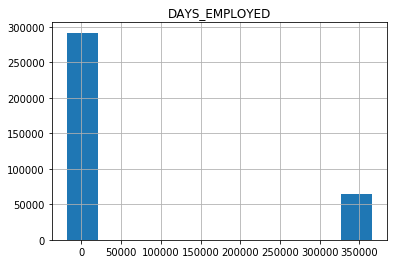

In [15]:
# fix some weird data
%matplotlib inline

# something weird afoot
application[["DAYS_EMPLOYED"]].hist();

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbd8152dc18>]],
      dtype=object)

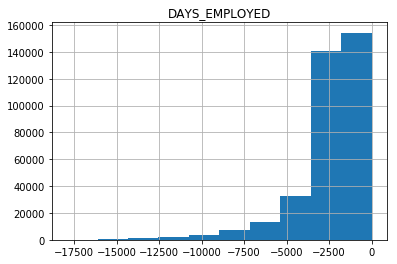

In [16]:
def fix_days_employed(df):
    df.loc[df["DAYS_EMPLOYED"] == 365243, "DAYS_EMPLOYED"] = np.nan
    df["DAYS_EMPLOYED"] = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(df[["DAYS_EMPLOYED"]])
    return df

fix_days_employed(application)
application[["DAYS_EMPLOYED"]].hist()

    

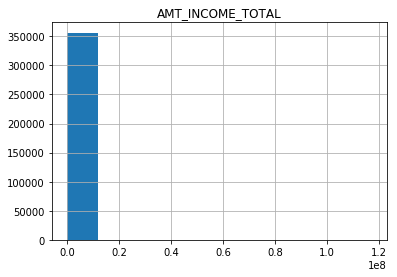

In [17]:
col = "AMT_INCOME_TOTAL"
application[[col]].hist();

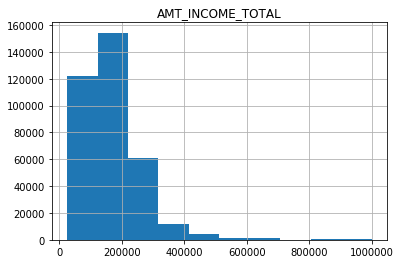

In [18]:
def fix_col_max(df, col, colmax):
    df.loc[df[col]>colmax, col] = colmax

fix_col_max(application, col, 1000000)
application[[col]].hist();

# Make binary labels, categorical dummies, interpolate missing numerical data

In [19]:
def make_categorical_dummies(df, categorical_cols):

    for col in categorical_cols:
        df[col] = df[col].astype(str)

    dummies = pd.get_dummies(df.loc[:,categorical])
    return dummies

make_categorical_dummies(application, categorical).head()

,AMT_REQ_CREDIT_BUREAU_DAY_0.0,AMT_REQ_CREDIT_BUREAU_DAY_1.0,AMT_REQ_CREDIT_BUREAU_DAY_2.0,AMT_REQ_CREDIT_BUREAU_DAY_3.0,AMT_REQ_CREDIT_BUREAU_DAY_4.0,AMT_REQ_CREDIT_BUREAU_DAY_5.0,AMT_REQ_CREDIT_BUREAU_DAY_6.0,AMT_REQ_CREDIT_BUREAU_DAY_8.0,AMT_REQ_CREDIT_BUREAU_DAY_9.0,AMT_REQ_CREDIT_BUREAU_DAY_nan,...,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY
0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [20]:
def make_binary_flags(df, binary_cols):
    binary_df = df.loc[:,binary_cols]

    # binarize values (y/n, m/f -> 0,1)
    for col in binary_cols:
        binary_df[col] = LabelBinarizer().fit_transform(binary_df[[col]])

    return binary_df

make_binary_flags(application, binary).head()

,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,...,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,NAME_CONTRACT_TYPE,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION
0,1,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0


In [21]:
def scrub_numerical(df, numerical_cols, verbose=False):
    numerical_df = df.loc[:,numerical_cols]

    # impute missing values
    for col in numerical_cols:
        if verbose:
            print(col)
        
        numerical_df[[col]] = SimpleImputer(missing_values=np.nan, 
                                            strategy='mean').fit_transform(numerical_df[[col]])
        
    return numerical_df

scrub_numerical(application, numeric).head()


,AMT_ANNUITY,AMT_CREDIT,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,BASEMENTAREA_AVG,CNT_CHILDREN,CNT_FAM_MEMBERS,...,RATE_INCOME_EXT2,RATE_INCOME_EXT3,RATE_PAYMENT_CREDIT,RATE_PAYMENT_EXT1,RATE_PAYMENT_EXT2,RATE_PAYMENT_EXT3,REGION_POPULATION_RELATIVE,TOTALAREA_MODE,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG
0,24700.5,406597.5,202500.0,0.000000,0.000000,1.000000,0.024700,0.036900,0.0,1.0,...,770112.507104,1.452907e+06,0.060749,297463.898020,93936.612255,177222.326450,0.018801,0.014900,0.972200,0.619200
1,35698.5,1293502.5,270000.0,0.000000,0.000000,0.000000,0.095900,0.052900,0.0,2.0,...,433912.146513,1.407878e+06,0.027598,114687.597106,57370.417638,229089.896524,0.003541,0.071400,0.985100,0.796000
2,6750.0,135000.0,67500.0,0.000000,0.000000,0.000000,0.118138,0.088673,0.0,1.0,...,121422.077369,9.252067e+04,0.050000,73634.035494,12142.207737,9252.067132,0.010032,0.103193,0.977889,0.752283
3,29686.5,312682.5,135000.0,0.231697,0.304399,1.911564,0.118138,0.088673,0.0,2.0,...,207551.271685,1.407878e+06,0.094941,73634.035494,45640.524644,229089.896524,0.008019,0.103193,0.977889,0.752283
4,21865.5,513000.0,121500.0,0.000000,0.000000,0.000000,0.118138,0.088673,0.0,1.0,...,376466.024966,1.407878e+06,0.042623,73634.035494,67749.941308,229089.896524,0.028663,0.103193,0.977889,0.752283


# Disaggregate, pickle training and test data

In [25]:
appdata = pd.concat((application[["TARGET"]],
                     application[["SK_ID_CURR"]],                     
                     scrub_numerical(application, numeric),
                     make_binary_flags(application, binary),
                     make_categorical_dummies(application, categorical)
                    ),
                    axis=1)

print(appdata.shape)
appdata.to_pickle("appdata.pickle")

# disaggregate train and test 
application_train = appdata.loc[appdata["TARGET"] != -1]
application_train.to_pickle("subsample2.pickle")

application_test = appdata.loc[appdata["TARGET"] == -1]
application_test = application_test.drop(columns=["TARGET"])
application_test.to_pickle("application_test.pickle")

appdata.head()

(356255, 290)


,TARGET,SK_ID_CURR,AMT_ANNUITY,AMT_CREDIT,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,BASEMENTAREA_AVG,...,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY
0,1,100002,24700.5,406597.5,202500.0,0.000000,0.000000,1.000000,0.024700,0.036900,...,1,0,0,0,0,0,0,0,0,1
1,0,100003,35698.5,1293502.5,270000.0,0.000000,0.000000,0.000000,0.095900,0.052900,...,0,0,0,0,1,0,0,0,0,0
2,0,100004,6750.0,135000.0,67500.0,0.000000,0.000000,0.000000,0.118138,0.088673,...,0,0,1,0,1,0,0,0,0,0
3,0,100006,29686.5,312682.5,135000.0,0.231697,0.304399,1.911564,0.118138,0.088673,...,0,0,1,0,0,0,0,0,0,1
4,0,100007,21865.5,513000.0,121500.0,0.000000,0.000000,0.000000,0.118138,0.088673,...,0,0,1,0,0,0,0,1,0,0


In [26]:
print(application_train.shape)
application_train.head()

(307511, 290)


,TARGET,SK_ID_CURR,AMT_ANNUITY,AMT_CREDIT,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,BASEMENTAREA_AVG,...,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY
0,1,100002,24700.5,406597.5,202500.0,0.000000,0.000000,1.000000,0.024700,0.036900,...,1,0,0,0,0,0,0,0,0,1
1,0,100003,35698.5,1293502.5,270000.0,0.000000,0.000000,0.000000,0.095900,0.052900,...,0,0,0,0,1,0,0,0,0,0
2,0,100004,6750.0,135000.0,67500.0,0.000000,0.000000,0.000000,0.118138,0.088673,...,0,0,1,0,1,0,0,0,0,0
3,0,100006,29686.5,312682.5,135000.0,0.231697,0.304399,1.911564,0.118138,0.088673,...,0,0,1,0,0,0,0,0,0,1
4,0,100007,21865.5,513000.0,121500.0,0.000000,0.000000,0.000000,0.118138,0.088673,...,0,0,1,0,0,0,0,1,0,0


In [27]:
print(application_test.shape)
application_test.head()

(48744, 289)


,SK_ID_CURR,AMT_ANNUITY,AMT_CREDIT,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,BASEMENTAREA_AVG,CNT_CHILDREN,...,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY
0,100001,20560.5,568800.0,135000.0,0.000000,0.000000,0.000000,0.066000,0.059000,0.0,...,1,0,0,0,0,0,0,0,1,0
1,100005,17370.0,222768.0,99000.0,0.000000,0.000000,3.000000,0.118138,0.088673,0.0,...,0,0,1,1,0,0,0,0,0,0
2,100013,69777.0,663264.0,202500.0,0.000000,1.000000,4.000000,0.118138,0.088673,0.0,...,0,0,1,0,1,0,0,0,0,0
3,100028,49018.5,1575000.0,315000.0,0.000000,0.000000,3.000000,0.305200,0.197400,2.0,...,0,0,0,0,0,0,0,0,0,1
4,100038,32067.0,625500.0,180000.0,0.231697,0.304399,1.911564,0.118138,0.088673,1.0,...,0,0,1,1,0,0,0,0,0,0


In [26]:
def subsample(df, n):
    # sample 10,000 row indexesfrom application_train (or use pd.sample)
    nrows, ncols = df.shape
    subsample_indexes = sorted(random.sample(range(nrows), n))
    return application_train.loc[subsample_indexes, :]
